In [1]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        
from imap.data.pixel_data_module import PixelDataModule
from imap.model.simple_nerf import NERF
from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import os
import torch
from tqdm.notebook import tqdm

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load image and depth

In [3]:
depth_image_path = "/media/mikhail/Data3T/7scenes/chess/seq-01/frame-000001.depth.png"
color_image_path = "/media/mikhail/Data3T/7scenes/chess/seq-01/frame-000001.color.png"

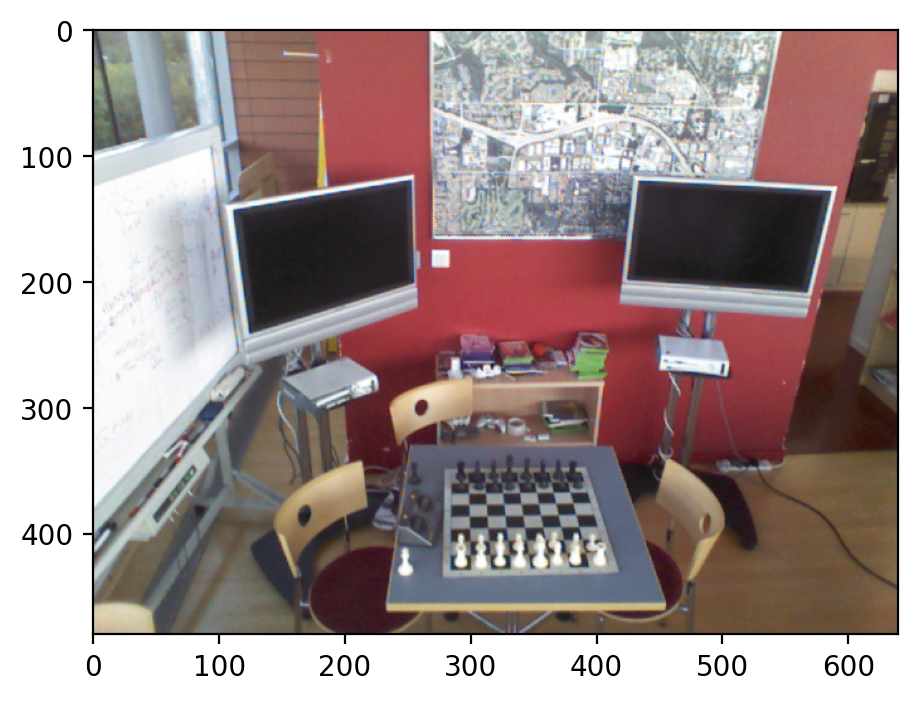

In [4]:
figure = plt.figure(dpi=200)
color_image = cv2.imread(color_image_path)
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR))

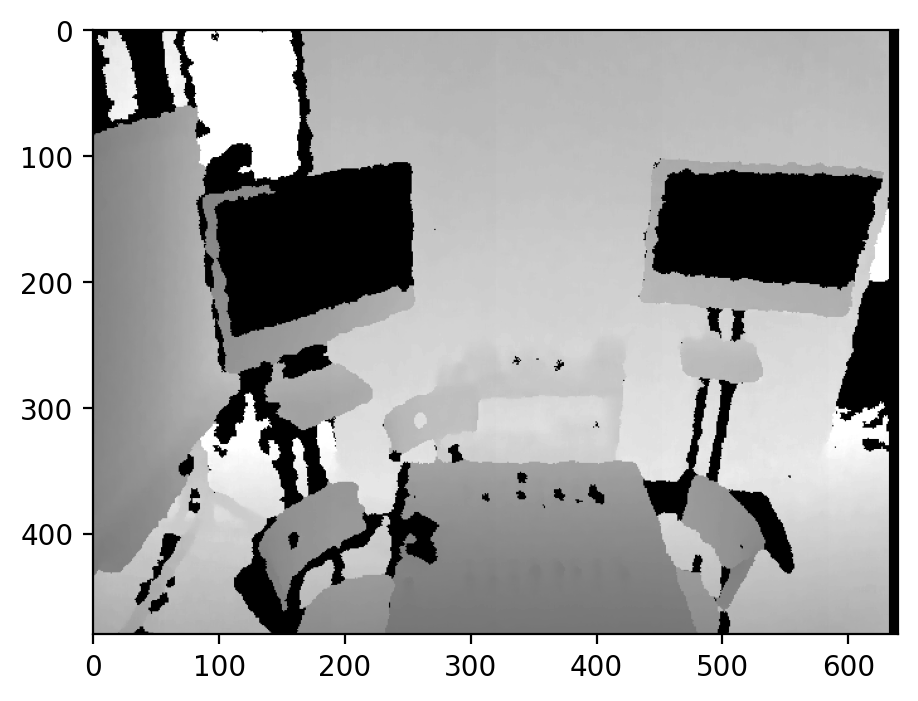

In [5]:
figure = plt.figure(dpi=200)
depth_image = cv2.imread(depth_image_path, -1).astype(np.float32) / 1000
depth_image = np.clip(depth_image, 0, 4)
plt.imshow(depth_image, cmap="gray")

# Random pixels

In [6]:
data_module = PixelDataModule(color_image_path, depth_image_path)

[ToyDataModule] - train subset size 301056
[ToyDataModule] - validation dataset size 6144


In [26]:
parameters = AttributeDict(
    name="NERF",
    optimizer=AttributeDict(),
    encoding_dimension=93,
    course_sample_bins=32,
    fine_sample_bins=12,
    maximal_distance=4,
    depth_loss_koef=0.5,
    encoding_sigma=5
)
factory = UniversalFactory([NERF])
model = factory.make_from_parameters(parameters, data_module=data_module)

In [27]:
# logger_path = os.path.join(os.path.dirname(task.cache_dir), "lightning_logs", "sparse_feature_pyramid")
logger_path = os.path.join("lightning_logs", "sparse_feature_pyramid")
trainer_parameters = {
    "max_epochs": 10,
    "checkpoint_every_n_val_epochs": 10,
    "gpus": 1,
    "check_val_every_n_epoch": 2
}
# task.connect(trainer_parameters)
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss',
    every_n_val_epochs=trainer_parameters["checkpoint_every_n_val_epochs"])
trainer = factory.kwargs_function(pl.Trainer)(
    logger=TensorBoardLogger(logger_path, name="chess"),
    callbacks=[model_checkpoint],
    **trainer_parameters
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [28]:
trainer.fit(model, data_module);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                       | Params
--------------------------------------------------------------------
0 | _fine_mlp            | MLP                        | 246 K 
1 | _course_mlp          | MLP                        | 246 K 
2 | _positional_encoding | GaussianPositionalEncoding | 279   
3 | _loss                | L1Loss                     | 0     
--------------------------------------------------------------------
492 K     Trainable params
0         Non-trainable params
492 K     Total params
1.971     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Show results

In [29]:
y, x = np.meshgrid(range(color_image.shape[0]), range(color_image.shape[1]))                                  
pixels = np.array([x, y], dtype=np.float32).T
pixels = torch.tensor(pixels).cuda().reshape(-1, 2)
positions = torch.repeat_interleave(torch.tensor(data_module._dataset._position)[None], pixels.shape[0],
                                  dim=0).cuda()

In [30]:
batch_size = 1024
batch_count = pixels.shape[0] // batch_size
output_course_color = []
output_course_depth = []
output_fine_color = []
output_fine_depth = []
model = model.cuda()
with torch.no_grad():
    for i in tqdm(range(batch_count)):
        output = model(pixels[i * batch_size:i * batch_size + batch_size],
                             positions[i * batch_size:i * batch_size + batch_size])
        output_course_color.append(output[0])
        output_course_depth.append(output[1])
        output_fine_color.append(output[2])
        output_fine_depth.append(output[3])

  0%|          | 0/300 [00:00<?, ?it/s]

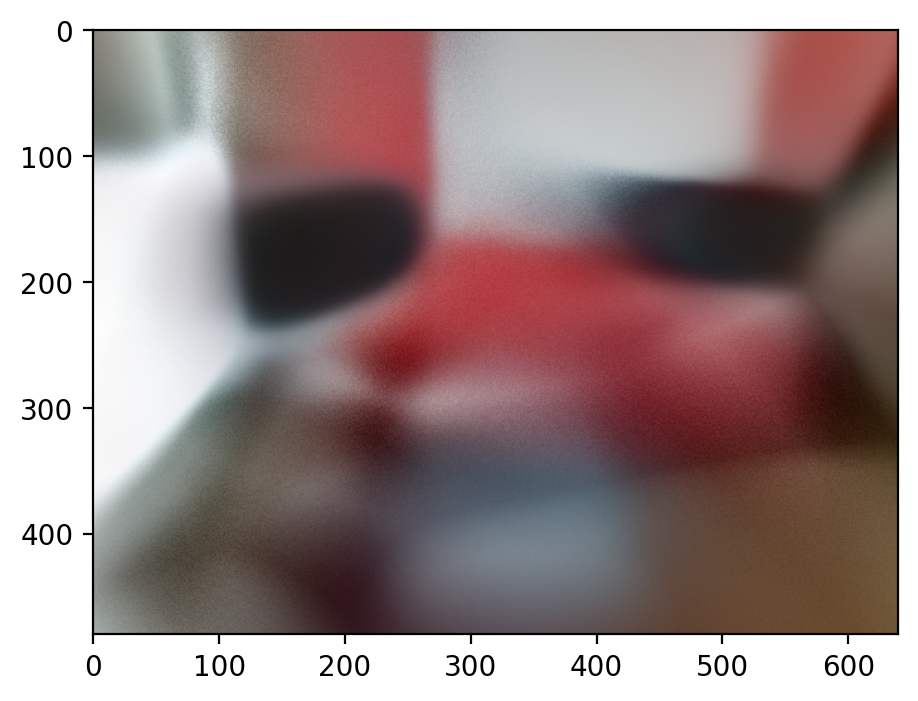

In [31]:
reconstructed_image = torch.cat(output_course_color, dim=0).reshape(480, 640, 3).detach().cpu().numpy()
mean = data_module._dataset._color_mean
std = data_module._dataset._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

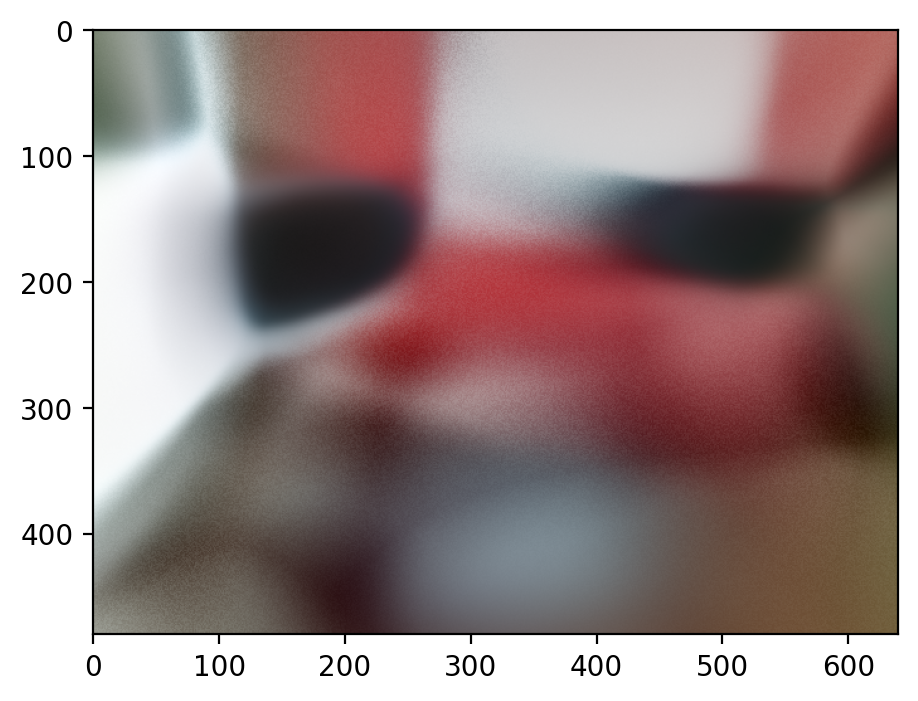

In [32]:
reconstructed_image = torch.cat(output_fine_color, dim=0).reshape(480, 640, 3).detach().cpu().numpy()
mean = data_module._dataset._color_mean
std = data_module._dataset._color_std
reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
reconstructed_image = np.clip(reconstructed_image / 255., 0, 1)
figure = plt.figure(dpi=200)
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

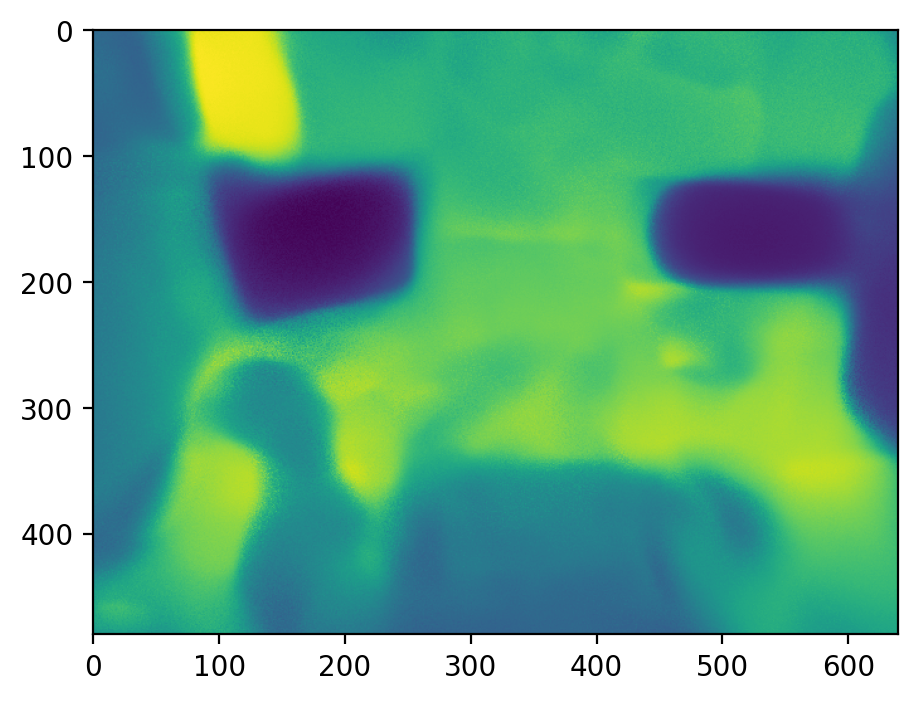

In [16]:
reconstructed_depth = torch.cat(output_course_depth, dim=0).reshape(480, 640).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(reconstructed_depth)

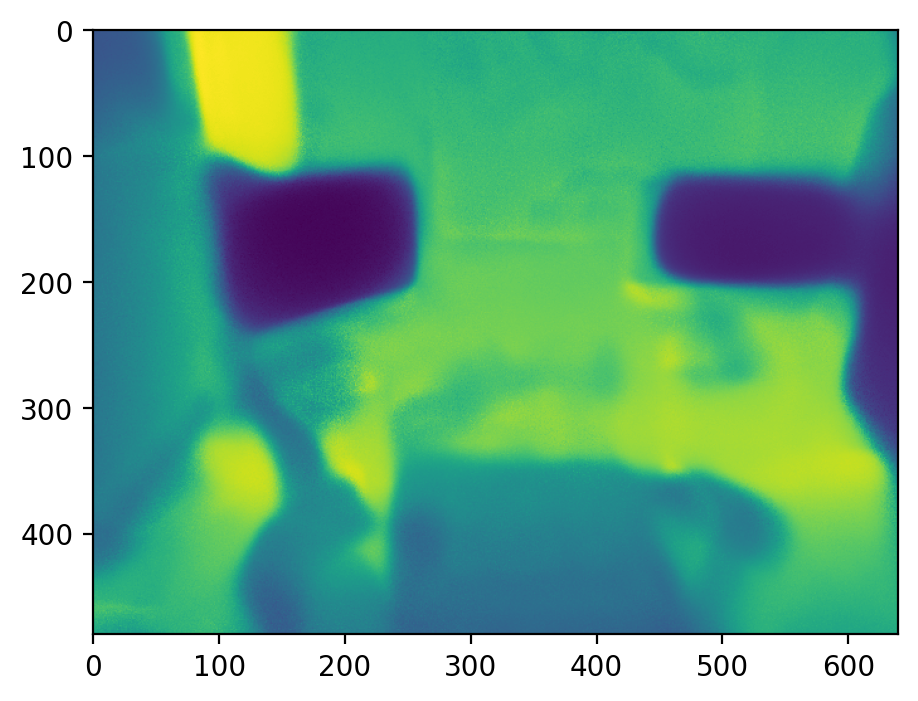

In [19]:
reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480, 640).detach().cpu().numpy()
figure = plt.figure(dpi=200)
plt.imshow(reconstructed_depth)